In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
from utils.utils import *
from dtw import dtw


np.random.seed(2)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


#### Import data

In [3]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [4]:
file_dir = r'D:\Study 2 Data\Healthy Gait\Train_Val' 
# file_dir = r'D:\Study 2 Data\CP Gait\Train'
train_files = os.listdir(file_dir) 

# Changes the working directory to get the data from their location 
os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\Healthy Gait\Train_Val
There are 9 files in the specified path.


In [5]:
train_files

['AB2188 BF T1-5.csv',
 'AB3154 BF T6-10.csv',
 'AB6751 BF T1-5.csv',
 'AB7422 BF T1-5.csv',
 'AB7779 BF T1-5.csv',
 'AB9119 BF T1-5.csv',
 'AB9737 BF T1-5.csv',
 'AB9737 BF T6-10.csv',
 'AB9738 BF T1-5.csv']

In [6]:
#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [7]:
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv
Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB6751 BF T1-5.csv
Extracting data from: AB7422 BF T1-5.csv
Extracting data from: AB7779 BF T1-5.csv
Extracting data from: AB9119 BF T1-5.csv
Extracting data from: AB9737 BF T1-5.csv
Extracting data from: AB9737 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv


In [8]:
all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [9]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
85147,AB9738 BF T1-5,10,357.98,10.99086,7.10503,6.93556,24.15779,24.79361,-6.96295
85148,AB9738 BF T1-5,10,357.99,10.66388,6.95092,7.04563,23.36649,23.37365,-6.78526
85149,AB9738 BF T1-5,10,358.00,10.47453,6.99232,7.14855,22.59988,22.00132,-6.50384
85150,AB9738 BF T1-5,10,358.01,10.44759,7.27248,7.23479,21.89250,20.71157,-6.14128


In [10]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 16


In [11]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB6751 BF T1-5',
       'AB7422 BF T1-5', 'AB7779 BF T1-5', 'AB9119 BF T1-5',
       'AB9737 BF T1-5', 'AB9737 BF T6-10', 'AB9738 BF T1-5'],
      dtype=object)

In [12]:
# # Healthy Subjects 
# train_subjects = ['AB2188 BF T1-5',
#                     'AB3154 BF T6-10', 
#                     'AB6751 BF T1-5',
#                     'AB7422 BF T1-5',
#                     'AB7779 BF T1-5', 
#                     'AB9737 BF T1-5', 
#                     'AB9737 BF T6-10', 
#                     'AB9738 BF T1-5']

# val_subjects = ['AB9119 BF T1-5']


In [13]:
# Healthy Subjects 
train_subjects = ['AB2188 BF T1-5',
                    'AB3154 BF T6-10', 
                    'AB6751 BF T1-5',
                    'AB7422 BF T1-5',
                    'AB7779 BF T1-5', 
                    'AB9737 BF T1-5', 
                    'AB9737 BF T6-10', 
                    'AB9119 BF T1-5',]

val_subjects = ['AB9738 BF T1-5']


# # Healthy Subjects 
# train_subjects = ['AB2188 BF T1-5',
#                     'AB3154 BF T6-10', 
#                     'AB6751 BF T1-5',
#                     'AB7422 BF T1-5',
#                     'AB7779 BF T1-5', 
#                     'AB9737 BF T1-5', 
#                     'AB9737 BF T6-10', 
#                     'AB9119 BF T1-5',]

# val_subjects = ['AB9738 BF T1-5']

In [14]:
val_subjects

['AB9738 BF T1-5']

In [15]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

In [16]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')

all_data: (85152, 9)
train_data: (76720, 9)
val_data: (8432, 9)


In [17]:
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)

For patient: AB2188 BF T1-5, trial: 1, there are: 718 time-points
For patient: AB2188 BF T1-5, trial: 2, there are: 801 time-points
For patient: AB2188 BF T1-5, trial: 3, there are: 706 time-points
For patient: AB2188 BF T1-5, trial: 4, there are: 651 time-points
For patient: AB2188 BF T1-5, trial: 5, there are: 741 time-points
For patient: AB2188 BF T1-5, trial: 6, there are: 691 time-points
For patient: AB2188 BF T1-5, trial: 7, there are: 722 time-points
For patient: AB2188 BF T1-5, trial: 8, there are: 726 time-points
For patient: AB2188 BF T1-5, trial: 9, there are: 740 time-points
For patient: AB2188 BF T1-5, trial: 10, there are: 766 time-points
For patient: AB3154 BF T6-10, trial: 1, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4, there are: 601 time-points
For patient: AB3154 BF T6-10, trial: 5, there are: 711 time-points
For 

In [18]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')

Number of train samples: 89
Number of validation samples: 9


In [19]:
m = all_data['Patient ID'].unique()

In [20]:

def pd_to_np_converter(data, n_samples, features):
    #create a numpy array that stores the data for export
    sample_ID = []
    # patients = 2
    # n_trials = 10
    # # samples = patients * n_trials
    data_store = np.zeros((n_samples, 2000, len(features)), dtype=np.float32)
    i = 0

    for p in data['Patient ID'].unique(): #loop over patients 
        for t in data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
            pd_array = data[(data['Patient ID'] == p) & (data['Trial'] == t)]
            if pd_array.empty:
                continue
                # print('DataFrame is empty!')
                # print(f'Trail {t} does not exist in {p}')
            else:
                np_array = pd_array.to_numpy()
                data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
                sample_ID.append(p+ ' Ts'+str(t)) 
                i +=1

    return pd_array.columns, data_store


In [21]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')

train_data_np.shape: (89, 2000, 6)
val_data_np.shape: (9, 2000, 6)


In [22]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [23]:
features == train_columns[3:].tolist() 

True

In [24]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('YAY! Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

YAY! Column headers of dataframe match features


In [25]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels
# labels_keys

{'Hips Flexion-Extension Left': 0,
 'Knees Flexion-Extension Left': 1,
 'Ankles Dorsiflexion-Plantarflexion Left': 2,
 'Hips Flexion-Extension Right': 3,
 'Knees Flexion-Extension Right': 4,
 'Ankles Dorsiflexion-Plantarflexion Right': 5}

In [26]:
def window_generator_fltrd(sequence, input_window, output_window, stride, features, labels):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - 300 #reducing sequence size to remove the first and last 200 timesteps which may contain errors   
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+output_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]

    return X_values, Y_values 

In [27]:
def window_generator_lt_fltrd(sequence, input_window, future_window, stride, features, labels): #window gernerator long term fltrd (creats a validation window up to 200 timesteps in advance to measure error on long term future predictions)
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    fltrd_samples = 2 * 150 #remove 100 timesteps from the beggining and ending of the entire sequence
    # lt_len = 200 # number of timesteps to predict in the future based on a single input window (to be used in measuring errors based on prediction input)
    
    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - (fltrd_samples) # (- fltrd_samples is done to reduce sequence size to remove the first and last 150 timesteps which may contain errors since they corresponding to beggining and ending of the trials 
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+future_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")
        # return None 

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), future_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + future_window, labels[feature]]

    return X_values, Y_values 

In [28]:
# Creating training datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float32)


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 318
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 401
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 306
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 341
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 291
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 322
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 326
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 340
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 366
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: 141
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 213
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
num

In [36]:
# Creating validation datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_windows[start_idx:end_idx, :, :] = X_values
    Y_val_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 581
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 601
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 506
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 558
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 551
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 504
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 526
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 509
shape of X_val_windows: (14400, 100, 6)
shape of Y_val_windows: (14400, 1, 6)
shape of X_val_data: (4832, 100, 6)
shape of Y_val_data: (4832, 1, 6)


In [37]:
# Creating validation datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_lt_sample_sum = 0
val_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_lt_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        future_window=future_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_lt_windows[start_idx:end_idx, :, :] = X_values
    Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_lt_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 382
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 402
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 307
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 359
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 352
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 305
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 327
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 310
shape of X_val_lt_windows: (14400, 100, 6)
shape of Y_val_lt_windows: (14400, 200, 6)
shape of X_val_lt_data: (3041, 100, 6)
shape of Y_val_lt_data: (3041, 200, 6)


In [38]:
scalars= np.array([[-45., -45., -90., -45., -45., -90.], [100., 120., 45., 100., 120., 45.]])



In [39]:
scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])

In [40]:
# X_train_norm, scalars = normalise_fit(X_train_data)
X_train_norm = normalise_transform(X_train_data, scalars)
Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)


scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])

In [41]:
# for i in range(6):
#     plt.hist(X_train_data[:,:,i].reshape(-1,1), label=features[i])
#     plt.legend()
#     plt.show()

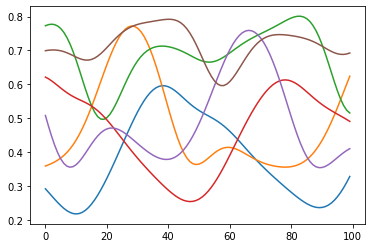

In [42]:
plt.plot(X_train_norm[2089,:])

In [43]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

# X_val = torch.from_numpy(X_val_norm).float()

# X_val_resized = np.expand_dims(Y_val_norm[:,0,:], axis=1)
# Y_val = torch.from_numpy(X_val_resized).float()

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions




X_train shape: torch.Size([41120, 100, 6])
Y_train shape: torch.Size([41120, 1, 6])
X_val shape: torch.Size([4832, 100, 6])
Y_val shape: torch.Size([4832, 1, 6])
X_val_lt shape: torch.Size([3041, 100, 6])
Y_val_lt shape: torch.Size([3041, 200, 6])


In [44]:
X_val.dtype

torch.float64

In [45]:
# [I 2022-10-02 15:32:21,183] Trial 27 finished with value: 5.606091948123196 and parameters: {'learning_rate': 1e-05, 'layers': 6, 'num_units': 100, 'batch_size': 128}. Best is trial 27 with value: 5.606091948123196.

In [46]:
train_dataset = gaitDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False) #256

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=len(train_dataset), shuffle=False)


val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions
val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=256, shuffle=False)


print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
print(f"Val_lt Dataset length: {len(val_lt_dataset)}")


Train Dataset length: 41120
Val Dataset length: 4832
Val_lt Dataset length: 3041


In [47]:
# len(train_dataloader)

### Model training


#### Another tutorial:
https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave

In [48]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([41120, 100, 6]), shape of Y_train: torch.Size([41120, 1, 6])


In [49]:
# train_dataset = gaitDataset(X_train, Y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = False)
# # train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False)

# val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
# # val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [50]:
look_back = 100

In [51]:
# train_dataset.shape
# train_labels.shape

In [52]:
# #Vanilla LSTM
# class Net(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(Net, self).__init__()
        
#         # self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         # out = self.fc1(x)
#         out = self.fc(out)
#         return out

In [53]:
# # Vanilla LSTM
# class LSTM(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(LSTM, self).__init__()
        
#         self.lstm = nn.LSTM(input_size=len(features), hidden_size=n_neurons, num_layers=2, batch_first = True)
#         self.fc = nn.Linear(n_neurons, len(features))

#     def forward(self, x):
#         # print(f'input shape: {x.shape}')
#         out, _ = self.lstm(x)

#         out = self.fc(out[:,-1])

#         return out.unsqueeze(1)

In [54]:
# # # useful resources: https://www.youtube.com/watch?v=8A6TEjG2DNw (LSTM Time Series Prediction Tutorial using PyTorch in Python | Coronavirus Daily Cases Forecasting)
# # LSTM model 
# class LSTM(nn.Module):
#     def __init__(self, n_neurons, look_back):
#         super(LSTM, self).__init__()
#         '''
#         nn.lstm: 
#         input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
#         hidden_size = number of features in hidden state
#         num_layers
#         batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
#         h_0 = (D * num_layers, batchSize, Hout)
#         c_0 = (D * num_layers, batchSize, Hcell)

#         output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
#         h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
#         C_0 = (D*num_layers, N, Hcell) final cell state for each element 

#         nn.linear:
#         input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
#         output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

#         '''
#         # Pytorch documentation: 
#         # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
#         # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
#         # >>> h0 = torch.randn(2, 3, 20)
#         # >>> c0 = torch.randn(2, 3, 20)
#         # >>> output, (hn, cn) = rnn(input, (h0, c0))

#         self.input_size = len(features)
#         self.hidden_size = n_neurons
#         self.num_layers = 2
#         self.in_seq_len = look_back
#         self.output_size = len(features)
#         self.out_seq_len = output_window
#         self.device = DEVICE
        
#         # nn.LSTM(features, hidden_size, number of layers)
#         self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

#         #nn.fc1
#         self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))
#         # self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


#     def forward(self, input_data):

#         # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
#         h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device) # input_data.shape[0] is equal to batch size
#         c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device)

#         #propagate through LSTM
#         lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
#         # print(f'shape h_out[-1] {h_out.shape}')
#         # propagate through linear layer 
#         fc1_out = self.fc1(h_out[-1])
       
#         preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
#         # print(f'preds.shape (after reshaping): {preds.shape}')
        
#         return preds

In [55]:
# # MLP
# class Net(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(Net, self).__init__()
#         self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
#         self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
#         # self.relu = nn.ReLU()
#     def forward(self, x):
#         # print(f'input: {x.shape}')
#         out = self.flatten(x)
#         # print(f'flatten output: {out.shape}')
#         out = self.fc1(out)
#         # out = self.relu(out)
#         # print(f'fc1 shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.shape}')
#         return out.unsqueeze(1)

In [56]:
# # MLP
# class MLP(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(MLP, self).__init__()

#         self.flatten = nn.Flatten(1,-1)
#         self.fc1 = nn.Linear(input_shape*len(features), n_neurons)
#         self.fc = nn.Linear(n_neurons, len(features))
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # print(f'input: {x.shape}')
#         out = self.flatten(x)
#         # print(f'flatten output: {out.shape}')
#         out = self.fc1(out)
#         out = self.relu(out)
#         # print(f'fc1 shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.shape}')
#         return out.unsqueeze(1)

In [57]:
# # MLP
# class MLP(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(MLP, self).__init__()
        
#         self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.fc2 = nn.Linear(n_neurons, n_neurons)

#         self.fc3 = nn.Linear(n_neurons, n_neurons)
 
#         # self.fc1 = nn.Linear(n_neurons, n_neurons)

#         # self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         # print(f'input shape: {x.permute(2,0,1).shape}')
#         # out, _ = self.lstm(x)
#         out = self.fc1(x.permute(2,0,1))
#         out = self.relu(out)

#         out = self.fc2(out)
#         out = self.relu(out)
        
#         out = self.fc3(out)
#         out = self.relu(out)

#         # print(f'lstm out shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.permute(1,0,2).shape}')
#         return out.permute(1,2,0)

In [58]:
# class MLP(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(MLP, self).__init__()
#         # self.flatten = nn.Flatten()
#         self.input_size = len(features)
#         self.output_size = len(features)
#         self.in_seq_len = input_shape
#         self.out_seq_len = 1
#         self.device = DEVICE 
#         self.layers = 3
#         self.num_units = 200
        

#         self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

#         # self.MLP = nn.Sequential(
#         #     nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, 200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, 200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, self.output_size*self.out_seq_len),
#         # )

#         linear_layers_lst = [] #linear layer list
 
#         for i in range(self.layers):
#             linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
#             linear_layers_lst.append(nn.ReLU())

       
#         linear_layers = tuple((linear_layers_lst))

#         self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
#                                 nn.ReLU(), 
#                                 *linear_layers, 
#                                 nn.Linear(self.num_units, self.output_size*self.out_seq_len))

#         # self.tanh = nn.Tanh()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # print(f'shape of x: {x.shape}')
#         out = self.flatten(x)
#         # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
#         # print(f'shape of flatten: {out.shape}')
#         out = self.MLP(out)
#         # print(f'shape of MLP: {out.shape}')
#         out = self.sigmoid(out)
#         preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
#         return preds

In [59]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''
        nn.Conv1d
        in_channels: number of features in input 
        out_channels: number of channels in output
        kernel_size: size of convolving layer
        stride: convolution stride
        padding=0
        dilation=1
        groups=1
        bias=True
        padding_mode='zeros'
        device=device 
        dtype=None

        nn.MaxPool1d
        kernel_size:
        stride=None: default is kernel_size
        padding=0:
        dilation=1
        return_indices=False
        ceil_mode=False

        torch.flatten (reshapes to 1D vector)
        input
        start_dim=0
        end_dim=- 1

        nn.Linear 
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
        '''
        # Pytorch documentation: 
        # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
        # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
        # >>> output = m(input~)


        # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
        # >>> input = torch.randn(20, 16, 50)
        # >>> output = m(input)
    
        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 256
        self.kernel_12 = 3
        self.kernel_34 = 3
        self.padding = 2
        self.stride = 2
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [60]:
# DEVICE = 'cpu'
DEVICE = 'cuda'

In [61]:
# n_neurons = 5

# model = LSTM(n_neurons, look_back).double().to(DEVICE)
# loss_function = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_loss = []
# val_loss = []
# lt_loss = []

# for epoch in tqdm(range(1000)):
#     train_loss_total = 0.
#     i = 0
#     model.train()
#     for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
#         i += 1
#         model.zero_grad()
#         # print(f'train_labels shape: {batch_inputs.shape}')

#         batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
#         # print(f'batch_inputs.shape {batch_inputs.shape}')
#         predictions = model(batch_inputs)
#         # print(f'predictions.shape {predictions.shape}')
#         # print(f'train_labels shape: {batch_targets.shape}')
#         loss = loss_function(predictions, batch_targets)

#         train_loss_total += loss.item()
#         loss.backward()
#         optimizer.step()
#     # print(f'len(dataloader): {len(train_dataloader)}')
#     train_loss_total = train_loss_total/len(train_dataloader)
#     train_loss.append(train_loss_total)

#     # Calculate validation loss
#     model.eval()
#     with torch.no_grad():
#         val_loss_total = 0.
#         for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
            

#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#             predictions = model(batch_inputs)
#             # print(f'train_labels shape: {train_labels.shape}')
#             loss = loss_function(predictions, batch_targets)
#             val_loss_total += loss.item()
    
#     val_loss_total = val_loss_total/len(val_dataloader)
#     val_loss.append(val_loss_total)

#     # Calculating long term loss
#     model.eval()
#     with torch.no_grad():
#         lt_loss_total = 0.

#         for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

#             extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)
#             # print(f'extrapolation.shape: {extrapolation.shape}')

#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#             current_inputs = batch_inputs
#             for i in range(200):
#                 # print(f'current_inputs.shape {current_inputs.shape}')
#                 predictions = model(current_inputs)
#                 # print(f'predictions.shape {predictions.shape}')

#                 extrapolation[:,i,:] = predictions.squeeze(1)
#                 # print(f'current_inputs[:,1:,:].shape {current_inputs[:,1:,:].shape}')
#                 # print(f'predictions.shape {predictions.shape}')

#                 #concat shape [batch_size, 99, len(features)] and [batch_size, 1, len(features)]
#                 current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

#             loss = loss_function(extrapolation, batch_targets)
       
#             lt_loss_total += loss.item()
    
#     lt_loss_total = lt_loss_total/len(val_lt_dataloader)
#     lt_loss.append(lt_loss_total)

#     #plot one sample of extraplation 

#     if epoch % 5 == 0:
#         x1 = np.arange(0,100)
#         x3 = np.arange(101,301)

#         fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
#         n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

#         text_size = 11
#         for f in range(len(features)):
#             axs[n[f][0],n[f][1]].plot(x1, batch_inputs[300,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
#             axs[n[f][0],n[f][1]].plot(x3, extrapolation[300,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
#             axs[n[f][0],n[f][1]].plot(x3, batch_targets[300,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
#             axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
#             axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
#             axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

#         plt.show()


#     print(f'Epoch: {epoch+1}, Train Loss: {train_loss_total}, Val Loss: {val_loss_total}, lt Loss: {lt_loss_total}')


        

In [63]:
fname = 'Exp083_221103_CNN_wide_norm'
folder_path = r'D:\Study 2 Results and Models\Study 2 Experiments' + '\\' + fname 
path = r'D:\Study 2 Results and Models\Study 2 Experiments' + '\\' + fname + '\\'  + fname + '.pth'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    print('File already exists, choose a different name')
    raise 
    

File already exists, choose a different name


RuntimeError: No active exception to reraise

  0%|          | 0/50 [00:00<?, ?it/s]

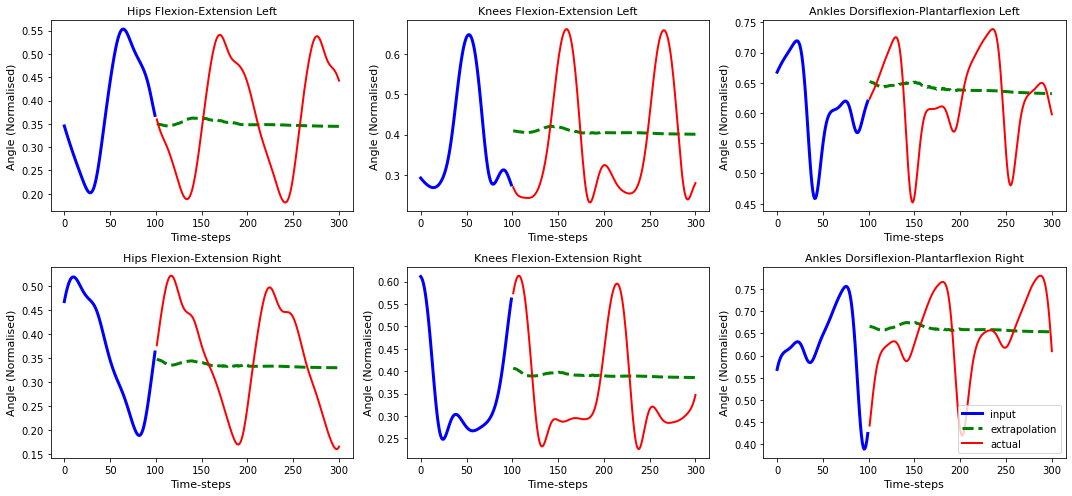

Epoch: 1, Train Loss: 0.060234591533288404, Val Loss: 0.01166203200302628, lt Loss: 0.01193088107487699, dtw distance: 18.173685864532107
New model saved!
Epoch: 2, Train Loss: 0.008831040194404751, Val Loss: 0.007813842750469018, lt Loss: 0.014689302466696495, dtw distance: 9.076954870014987
New model saved!
Epoch: 3, Train Loss: 0.004270015234752591, Val Loss: 0.005679267237854912, lt Loss: 0.016616135409273744, dtw distance: 7.13860978206026
New model saved!
Epoch: 4, Train Loss: 0.002428411599881105, Val Loss: 0.003652107446442719, lt Loss: 0.014705587598163353, dtw distance: 6.21130450472873
New model saved!
Epoch: 5, Train Loss: 0.0016246018301476826, Val Loss: 0.0029780936736880474, lt Loss: 0.014198153445449816, dtw distance: 5.3860182273034525
New model saved!


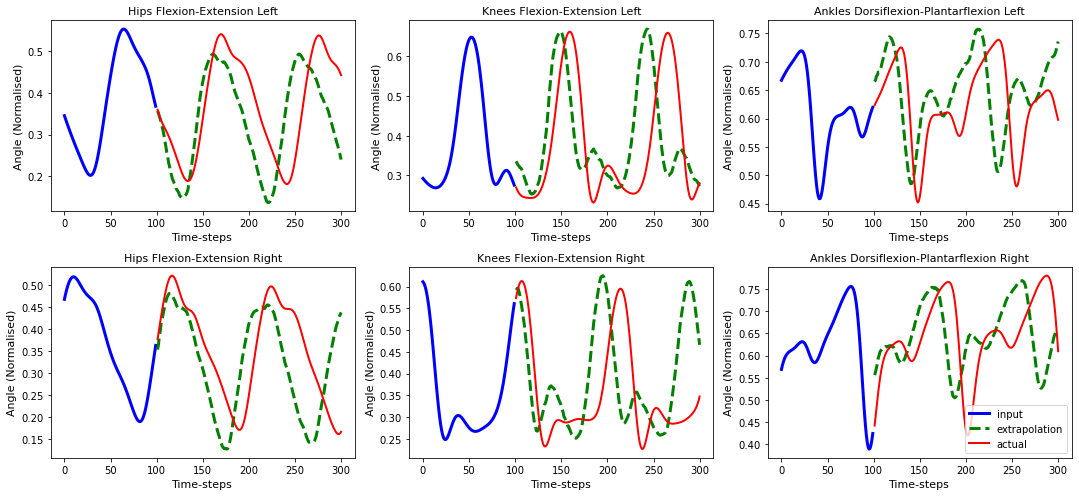

Epoch: 6, Train Loss: 0.0012929524190703036, Val Loss: 0.0025117804272744996, lt Loss: 0.012397824935180525, dtw distance: 4.676845031276993
New model saved!
Epoch: 7, Train Loss: 0.0010650024897256448, Val Loss: 0.0021481228142252156, lt Loss: 0.01179104150137067, dtw distance: 4.7330800338585055
Epoch: 8, Train Loss: 0.0008941795491711002, Val Loss: 0.0018049631836183845, lt Loss: 0.009643032594839195, dtw distance: 4.3417476732933356
New model saved!
Epoch: 9, Train Loss: 0.0007610595423296443, Val Loss: 0.0016618632473211594, lt Loss: 0.011698233038828948, dtw distance: 4.847216431025751
Epoch: 10, Train Loss: 0.0006603587580379052, Val Loss: 0.0013966766862856625, lt Loss: 0.012130164144568788, dtw distance: 4.710731177416492


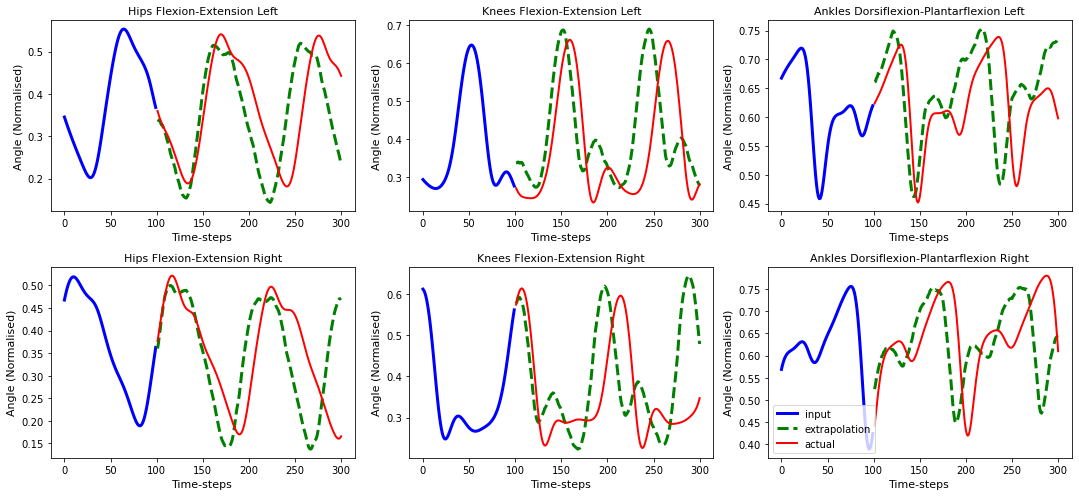

Epoch: 11, Train Loss: 0.0005793191788029849, Val Loss: 0.0011806821949761873, lt Loss: 0.012532153939633306, dtw distance: 4.60270149092604
Epoch: 12, Train Loss: 0.0005130329975877631, Val Loss: 0.0010631888556546006, lt Loss: 0.012135608064002512, dtw distance: 4.706471920526181
Epoch: 13, Train Loss: 0.0004558953616148569, Val Loss: 0.0009775926786947079, lt Loss: 0.013532260978577427, dtw distance: 5.036328868748025
Epoch: 14, Train Loss: 0.00041012860915445886, Val Loss: 0.0008158569524425276, lt Loss: 0.01406393743619177, dtw distance: 5.234871003798908
Epoch: 15, Train Loss: 0.00036978569464849077, Val Loss: 0.000696420583156248, lt Loss: 0.012196031877837082, dtw distance: 4.98869739731252


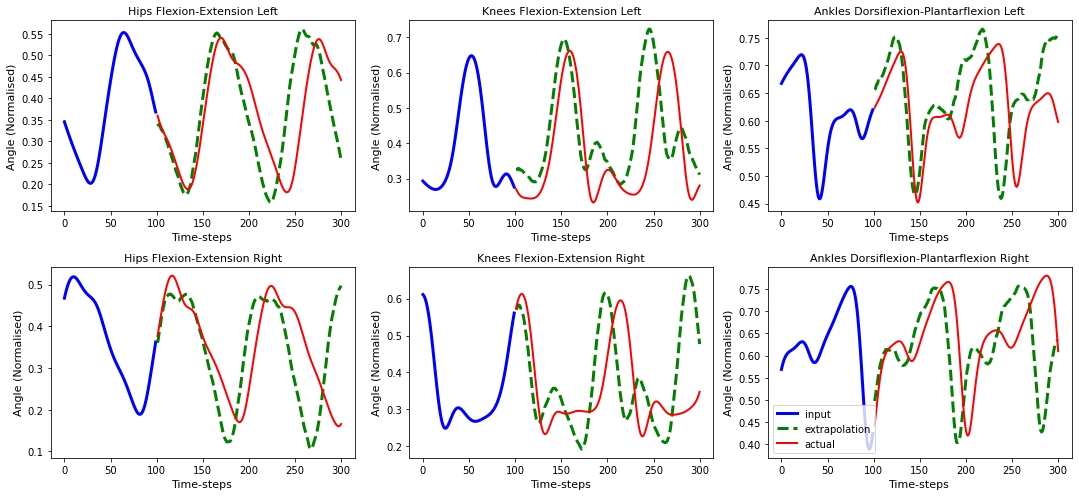

Epoch: 16, Train Loss: 0.0003375249343548154, Val Loss: 0.0006247834071076001, lt Loss: 0.014800880371605705, dtw distance: 5.4039960665371956
Epoch: 17, Train Loss: 0.0003083945034228249, Val Loss: 0.0005670929923967947, lt Loss: 0.014787373075367356, dtw distance: 5.579615310317048
Epoch: 18, Train Loss: 0.0002835992263427019, Val Loss: 0.0005102199510312563, lt Loss: 0.016166556208186314, dtw distance: 5.778562618218108
Epoch: 19, Train Loss: 0.0002626992266993533, Val Loss: 0.00046865005992366963, lt Loss: 0.014090825056677983, dtw distance: 5.091638742536433
Epoch: 20, Train Loss: 0.00024662622768658183, Val Loss: 0.0004274195952876911, lt Loss: 0.012853219927566426, dtw distance: 4.769243489883816


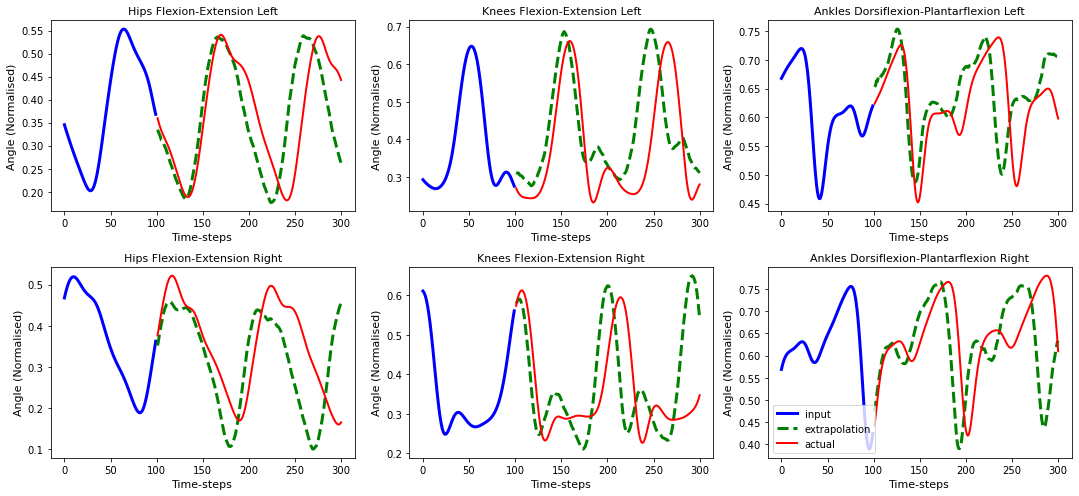

Epoch: 21, Train Loss: 0.0002290136010161516, Val Loss: 0.0003981434648610554, lt Loss: 0.013283911120472995, dtw distance: 4.8063556293775
Epoch: 22, Train Loss: 0.00021267108290969324, Val Loss: 0.00033482313758776577, lt Loss: 0.014838531848815869, dtw distance: 5.022490072968796
Epoch: 23, Train Loss: 0.00020072567140268813, Val Loss: 0.0003206380787015927, lt Loss: 0.012756756736473618, dtw distance: 5.09704330119498
Epoch: 24, Train Loss: 0.00018898479924112161, Val Loss: 0.0002880439289441509, lt Loss: 0.01432647645839147, dtw distance: 5.336424646615126
Epoch: 25, Train Loss: 0.0001787216843212824, Val Loss: 0.00027122671594802743, lt Loss: 0.01429784045252277, dtw distance: 5.211312767677895


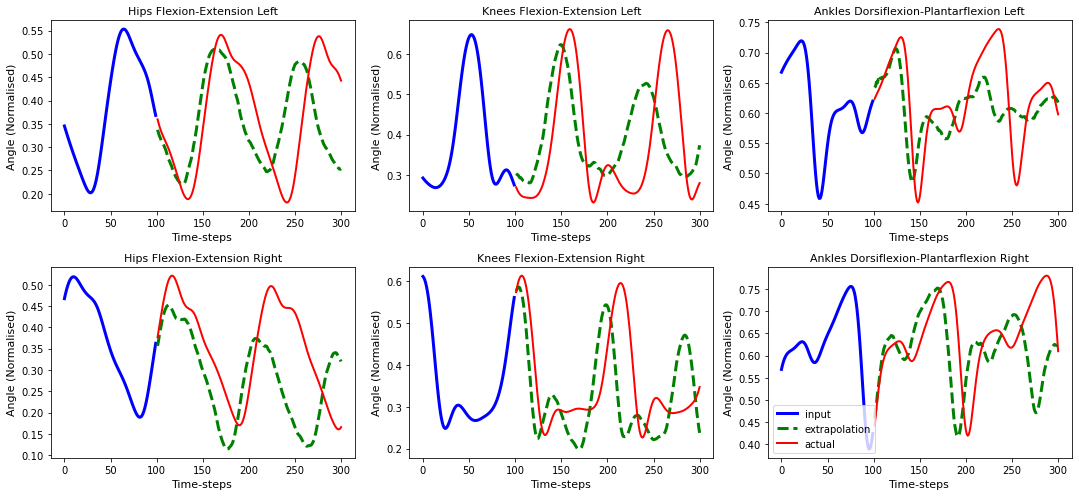

Epoch: 26, Train Loss: 0.00016830096636935717, Val Loss: 0.0002615254204514415, lt Loss: 0.009946872827341377, dtw distance: 5.344454308779329
Epoch: 27, Train Loss: 0.00015924682853941369, Val Loss: 0.0002435162027267958, lt Loss: 0.013260354578091604, dtw distance: 5.04816053977554
Epoch: 28, Train Loss: 0.00015218950719206195, Val Loss: 0.0002331285220587123, lt Loss: 0.01178714810707846, dtw distance: 4.5633481215139495
Epoch: 29, Train Loss: 0.00014276830431314634, Val Loss: 0.0002015650541941152, lt Loss: 0.012353535779248782, dtw distance: 4.711346953876013
Epoch: 30, Train Loss: 0.00013679609972535518, Val Loss: 0.00021624425150251433, lt Loss: 0.01286910059848819, dtw distance: 5.050332765212715


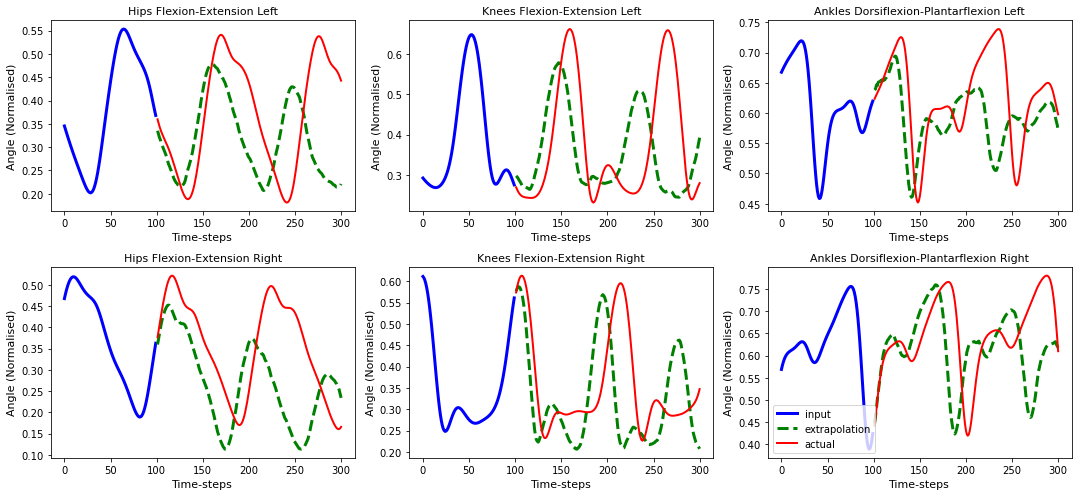

Epoch: 31, Train Loss: 0.0001296125083576187, Val Loss: 0.0002074098931863499, lt Loss: 0.01409889386869622, dtw distance: 6.217261377340743
Epoch: 32, Train Loss: 0.00012359130651083252, Val Loss: 0.00018165162030838686, lt Loss: 0.013629900836229634, dtw distance: 4.685549813138063
Epoch: 33, Train Loss: 0.00011765060723039407, Val Loss: 0.0001852266422535898, lt Loss: 0.011523095539513443, dtw distance: 5.0204589033249265
Epoch: 34, Train Loss: 0.00011205603912362808, Val Loss: 0.0001686373793675426, lt Loss: 0.014552711762776302, dtw distance: 4.995548644583226
Epoch: 35, Train Loss: 0.00010576766698309989, Val Loss: 0.0001693247773862011, lt Loss: 0.01333891130958918, dtw distance: 5.138305968070312


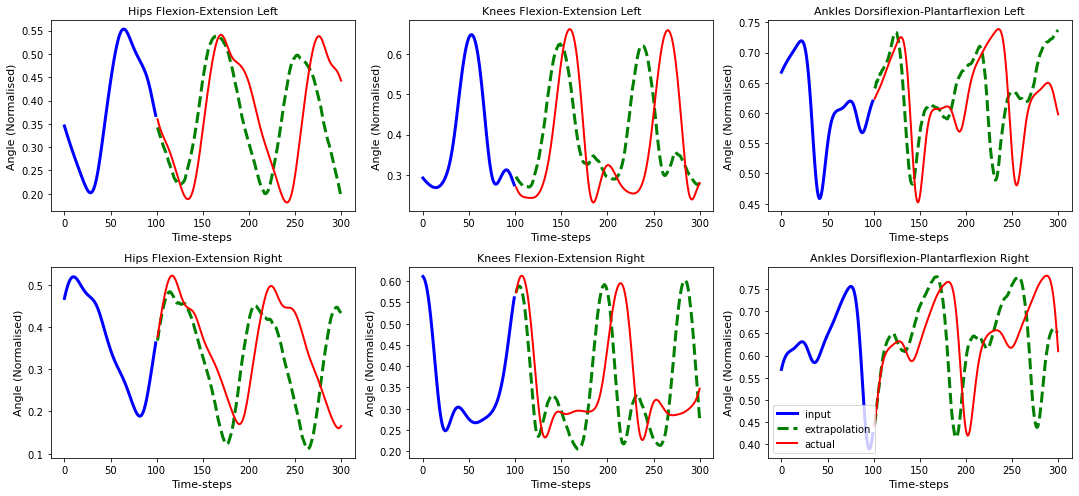

Epoch: 36, Train Loss: 0.0001007037409623396, Val Loss: 0.000151095951052767, lt Loss: 0.01333641864590715, dtw distance: 4.88023681558626
Epoch: 37, Train Loss: 9.638936138861436e-05, Val Loss: 0.00014733802788962312, lt Loss: 0.013495335270476439, dtw distance: 4.711567415735458
Epoch: 38, Train Loss: 9.201890995947211e-05, Val Loss: 0.00014022215163879192, lt Loss: 0.0123648622217298, dtw distance: 4.84532010490546
Epoch: 39, Train Loss: 8.869624509371897e-05, Val Loss: 0.00015446635631089254, lt Loss: 0.016343052518001736, dtw distance: 5.7568422577907326
Epoch: 40, Train Loss: 8.491509170106982e-05, Val Loss: 0.0001364293370215665, lt Loss: 0.014558338020189807, dtw distance: 5.312511037967319


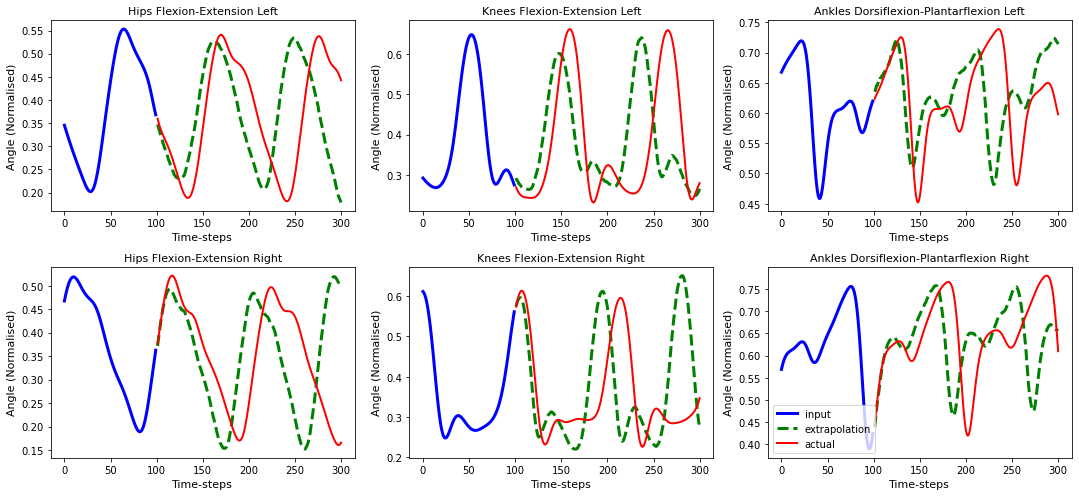

Epoch: 41, Train Loss: 8.073164082008345e-05, Val Loss: 0.00011624175782742902, lt Loss: 0.017955603369505944, dtw distance: 5.864195282680246
Epoch: 42, Train Loss: 7.680266679348425e-05, Val Loss: 0.00011997338625452123, lt Loss: 0.01365834752477338, dtw distance: 4.9888430936093995
Epoch: 43, Train Loss: 7.377617015534101e-05, Val Loss: 0.00011820601447148681, lt Loss: 0.013735441530269758, dtw distance: 4.976974679432152
Epoch: 44, Train Loss: 7.078775481194579e-05, Val Loss: 0.00010628866695046236, lt Loss: 0.013981336610008284, dtw distance: 4.898903783438389
Epoch: 45, Train Loss: 6.714066632579094e-05, Val Loss: 0.00010933893277364197, lt Loss: 0.016547594093279185, dtw distance: 6.088431634976055


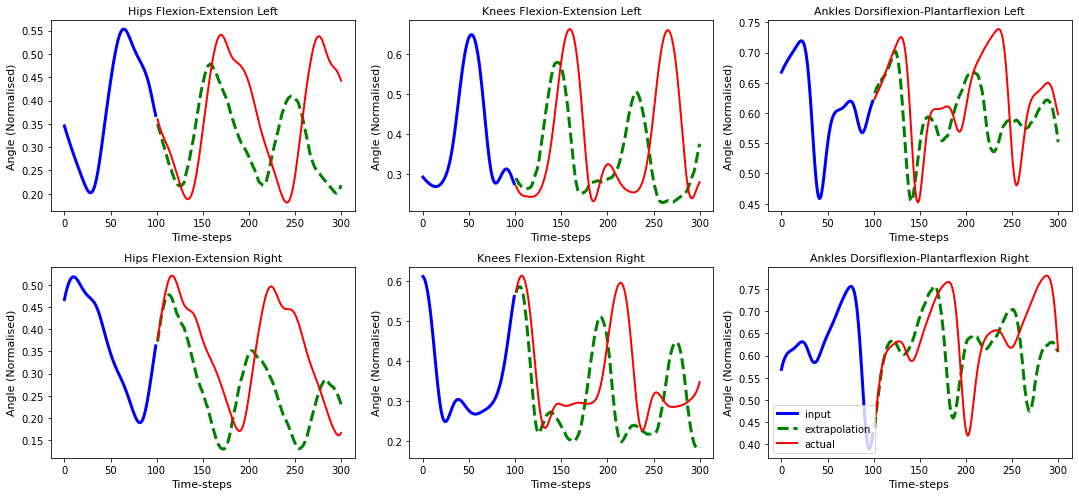

Epoch: 46, Train Loss: 6.536769552963578e-05, Val Loss: 0.000106557487241205, lt Loss: 0.014687379050337781, dtw distance: 6.682537507125975
Epoch: 47, Train Loss: 6.24954411103106e-05, Val Loss: 0.0001001609726085935, lt Loss: 0.012922460950011044, dtw distance: 4.733410791981262
Epoch: 48, Train Loss: 5.9866250091797626e-05, Val Loss: 0.00010466900857887449, lt Loss: 0.0173458453561777, dtw distance: 5.967905624327223
Epoch: 49, Train Loss: 5.749049562253781e-05, Val Loss: 9.214585142184186e-05, lt Loss: 0.015018739907620746, dtw distance: 5.1763491413521505
Epoch: 50, Train Loss: 5.6256009879530236e-05, Val Loss: 9.605626479278116e-05, lt Loss: 0.015474996812862974, dtw distance: 5.160318690068585


In [64]:
n_neurons = 200
model = CNN().double().to(DEVICE)
# model = MLP(n_neurons, look_back).double().to(DEVICE)
# model = LSTM(n_neurons, look_back).double().to(DEVICE)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
val_loss = []
lt_loss = []
dtw_loss = []

lowest_dtw = 1000.

for epoch in tqdm(range(50)):
    train_loss_total = 0.
    i = 0
    model.train()
    for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
        i += 1
        model.zero_grad()
        # print(f'train_labels shape: {batch_inputs.shape}')

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        # print(f'batch_inputs.shape {batch_inputs.shape}')
        predictions = model(batch_inputs)
        # print(f'predictions.shape {predictions.shape}')
        # print(f'train_labels shape: {batch_targets.shape}')
        loss = loss_function(predictions, batch_targets)

        train_loss_total += loss.item()
        loss.backward()
        optimizer.step()
    # print(f'len(dataloader): {len(train_dataloader)}')
    train_loss_total = train_loss_total/len(train_dataloader)
    train_loss.append(train_loss_total)

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_loss_total = 0.
        for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
            

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            predictions = model(batch_inputs)
            # print(f'train_labels shape: {train_labels.shape}')
            loss = loss_function(predictions, batch_targets)
            val_loss_total += loss.item()
    
    val_loss_total = val_loss_total/len(val_dataloader)
    val_loss.append(val_loss_total)

    # Calculating long term loss
    model.eval()
    with torch.no_grad():
        lt_loss_total = 0.
        dtw_total = 0.

        for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

            extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)
            # print(f'extrapolation.shape: {extrapolation.shape}')

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            current_inputs = batch_inputs
            for i in range(200):
                # print(f'current_inputs.shape {current_inputs.shape}')
                predictions = model(current_inputs)
                # print(f'predictions.shape {predictions.shape}')

                extrapolation[:,i,:] = predictions.squeeze(1)
                # print(f'current_inputs[:,1:,:].shape {current_inputs[:,1:,:].shape}')
                # print(f'predictions.shape {predictions.shape}')

                #concat shape [batch_size, 99, len(features)] and [batch_size, 1, len(features)]
                current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

            loss = loss_function(extrapolation, batch_targets)
    
            lt_loss_total += loss.item()

            #dtw
            running_dtw = 0.
            for s in range(batch_targets.shape[0]):
                for f in range(len(features)):
                    dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                    
                    running_dtw += dis

            dtw_total += running_dtw / (batch_targets.shape[0] * len(features))

    lt_loss_total = lt_loss_total/len(val_lt_dataloader)
    lt_loss.append(lt_loss_total)

    dtw_total = dtw_total / (len(val_lt_dataloader))
    dtw_loss.append(dtw_total)

    # plot one sample of extraplation 

    if epoch % 5 == 0:
        x1 = np.arange(0,100)
        x3 = np.arange(101,301)

        fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
        n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

        text_size = 11
        for f in range(len(features)):
            axs[n[f][0],n[f][1]].plot(x1, batch_inputs[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
            axs[n[f][0],n[f][1]].plot(x3, extrapolation[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='g',linestyle='dashed', label='extrapolation')
            axs[n[f][0],n[f][1]].plot(x3, batch_targets[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
            axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
            axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
            axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

        plt.legend()
        plt.show()
        

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_total}, Val Loss: {val_loss_total}, lt Loss: {lt_loss_total}, dtw distance: {dtw_total}')


    if dtw_total < lowest_dtw:
        print('New model saved!')
        lowest_dtw = dtw_total
        
        checkpoint = {'model': model,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, path)

In [65]:
path

'D:\\Study 2 Results and Models\\Study 2 Experiments\\Exp083_221103_CNN_wide_norm\\Exp083_221103_CNN_wide_norm.pth'

In [66]:
for t in range(40):
    print(f'Epoch{t+1}: train_loss: {train_loss[t]}, val_loss: {val_loss[t]}, lt_loss: {lt_loss[t]}, dtw_loss: {dtw_loss[t]}')

Epoch1: train_loss: 0.060234591533288404, val_loss: 0.01166203200302628, lt_loss: 0.01193088107487699, dtw_loss: 18.173685864532107
Epoch2: train_loss: 0.008831040194404751, val_loss: 0.007813842750469018, lt_loss: 0.014689302466696495, dtw_loss: 9.076954870014987
Epoch3: train_loss: 0.004270015234752591, val_loss: 0.005679267237854912, lt_loss: 0.016616135409273744, dtw_loss: 7.13860978206026
Epoch4: train_loss: 0.002428411599881105, val_loss: 0.003652107446442719, lt_loss: 0.014705587598163353, dtw_loss: 6.21130450472873
Epoch5: train_loss: 0.0016246018301476826, val_loss: 0.0029780936736880474, lt_loss: 0.014198153445449816, dtw_loss: 5.3860182273034525
Epoch6: train_loss: 0.0012929524190703036, val_loss: 0.0025117804272744996, lt_loss: 0.012397824935180525, dtw_loss: 4.676845031276993
Epoch7: train_loss: 0.0010650024897256448, val_loss: 0.0021481228142252156, lt_loss: 0.01179104150137067, dtw_loss: 4.7330800338585055
Epoch8: train_loss: 0.0008941795491711002, val_loss: 0.0018049631

In [67]:
#load model 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(path)

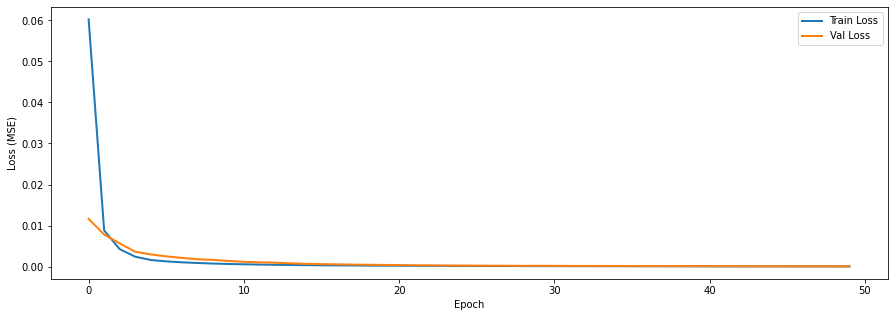

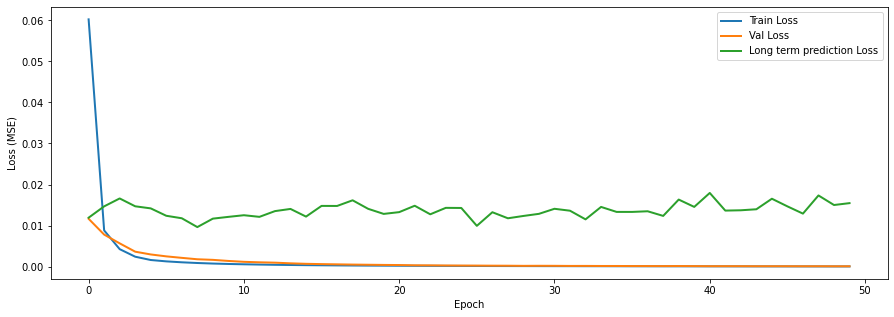

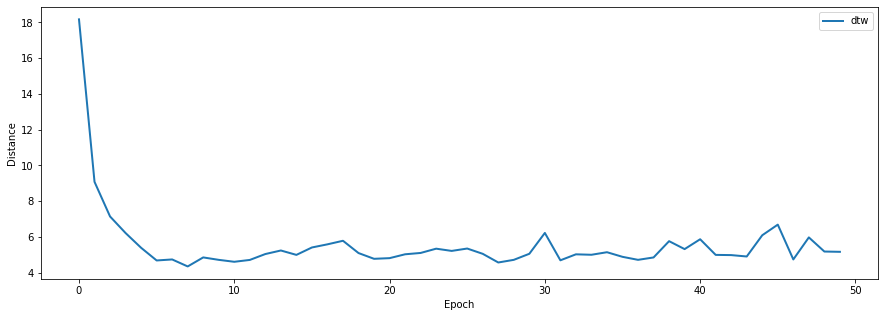

In [68]:

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')
ax.plot(lt_loss[:], lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dtw_loss, lw=2, label='dtw')
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.legend()
plt.show()

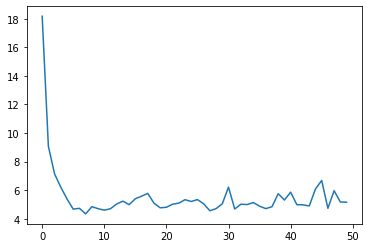

In [69]:
plt.plot(dtw_loss)

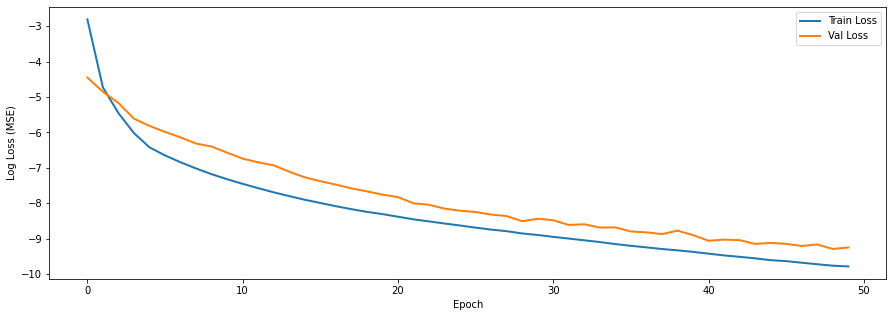

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(np.log(train_loss[:]), lw=2, label='Train Loss')
ax.plot(np.log(val_loss[:]), lw=2, label='Val Loss')
# ax.plot(np.log(lt_loss[:]), lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Log Loss (MSE)")
ax.legend()
plt.show()

In [71]:
test_dataset = X_val_lt.to(DEVICE)
with torch.no_grad():
    test_predictions = model(test_dataset)

test_predictions.shape

torch.Size([3041, 1, 6])

In [72]:
#Single Joint Plot
# x1 = np.arange(0,100)
# x2 = 101
# s = 200

# fig, ax = plt.subplots(1,1,figsize=(15,5))

# plt.plot(x1, test_dataset[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
# plt.scatter(x2, test_predictions[s,:,0].cpu().numpy(), lw=6, c='g', label='prediction')

# plt.xlabel('Time-steps')
# plt.ylabel('Angle (normalised)')
# ax.legend(loc='lower left')
# plt.show()

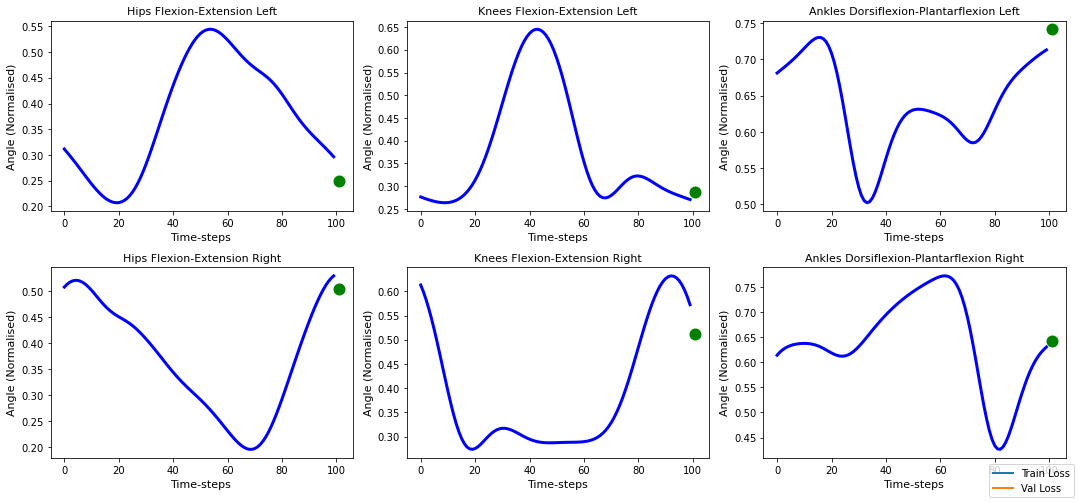

In [73]:
x1 = np.arange(0,100)
x2 = 101
s = 500

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11

for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, test_dataset[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, test_predictions[s,:,f].cpu().numpy(), lw=6, c='g', label='prediction')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

axLine, axLabel = ax.get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'lower right')

In [74]:
extrapolation = torch.zeros((1,200, len(features))).to(DEVICE)
seed_batch = test_dataset[s,:,:].unsqueeze(0).to(DEVICE)
current_batch = seed_batch
with torch.no_grad():
    for i in range(200):
        predicted_value = model(current_batch)
        extrapolation[:,i,:] = predicted_value
        current_batch = torch.cat((current_batch[:,1:,:], predicted_value), axis=1)

seed_batch.shape

torch.Size([1, 100, 6])

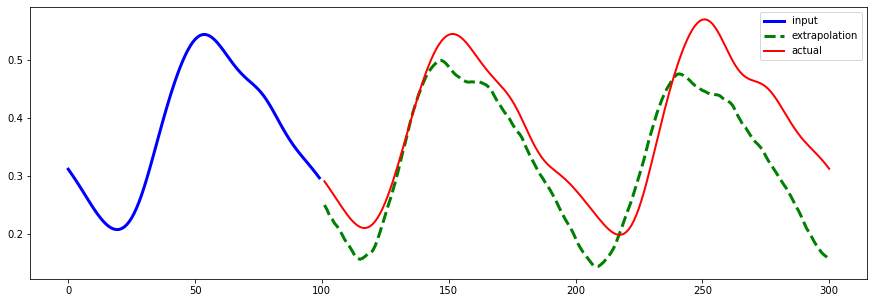

In [75]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(x1, seed_batch[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.plot(x3, extrapolation[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
plt.plot(x3, Y_val_lt[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
plt.legend()

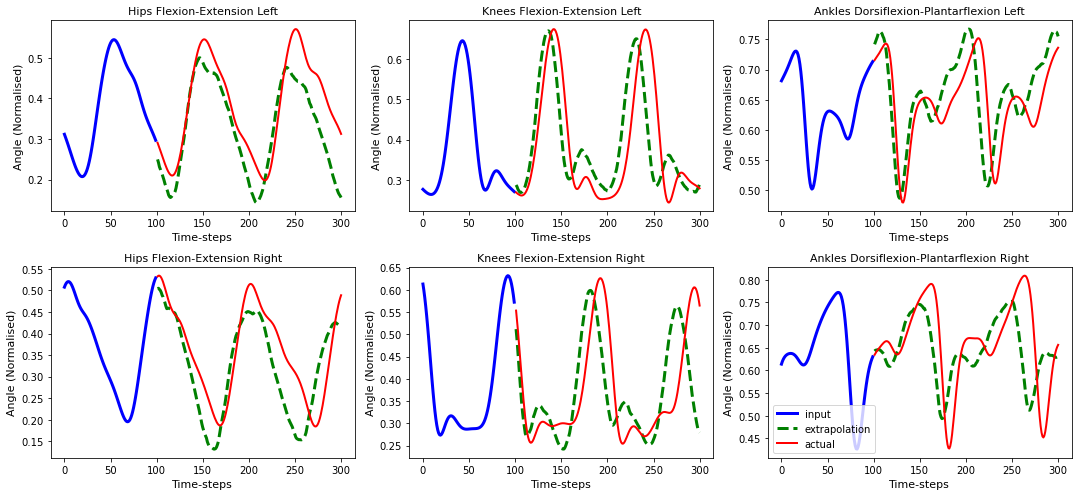

In [76]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, seed_batch[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, Y_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()


### Calculating MSE and MAE

In [77]:
print(f'shape of X validation data: {X_val.shape}, Y validation data: {Y_val.shape}')

shape of X validation data: torch.Size([4832, 100, 6]), Y validation data: torch.Size([4832, 1, 6])


In [78]:
# Calculate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_val.to(DEVICE))

#Denormalise X_val and Y_val and predictions 
input_val = denormalise(X_val.cpu().numpy(), scalars)
actual_val = denormalise(Y_val.cpu().numpy(), scalars)
preds_val = denormalise(test_predictions.cpu().numpy(), scalars)

In [79]:
# mse = np.mean((actual_val-preds_val) ** 2)
# mae = np.mean(np.abs(actual_val-preds_val))

val_mse_loss, val_mse_std = mse_loss(preds_val, actual_val, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(preds_val, actual_val, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss:.5}, Val MSE std: {val_mse_std:.5}')
print(f'Val MAE Loss: {val_mae_loss:.5}, Val MAE std: {val_mae_std:.5}')


Val MSE Loss: 41.014, Val MSE std: 64.244
Val MAE Loss: 4.9798, Val MAE std: 4.0269


In [80]:
for f in range(len(features)):
    print(f' error for {features[f]} is: {np.mean(abs(preds_val[:,:,f]-actual_val[:,:,f])):.3f}')

 error for Hips Flexion-Extension Left is: 3.745
 error for Knees Flexion-Extension Left is: 7.581
 error for Ankles Dorsiflexion-Plantarflexion Left is: 4.032
 error for Hips Flexion-Extension Right is: 3.979
 error for Knees Flexion-Extension Right is: 5.730
 error for Ankles Dorsiflexion-Plantarflexion Right is: 4.811


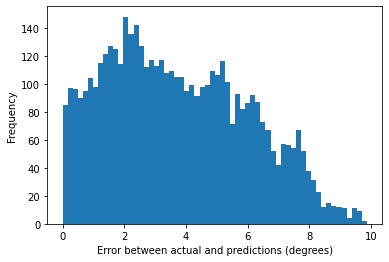

In [81]:
diff = abs(preds_val[:,:,0] -actual_val[:,:,0])
plt.hist(diff.squeeze(), 60)
plt.xlabel('Error between actual and predictions (degrees)')
plt.ylabel('Frequency')
plt.show()

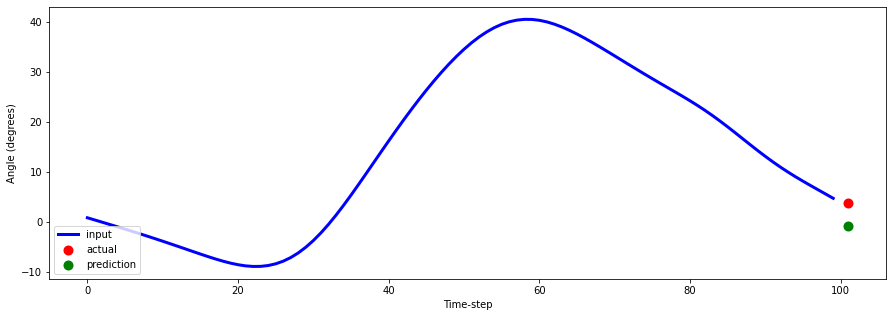

In [82]:
x1 = np.arange(0,100)
x2 = 101

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(x1, input_val[s,:,0].reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.scatter(x2, actual_val[s,:,0], lw=4, c='r', label='actual')
plt.scatter(x2, preds_val[s,:,0], lw=4, c='g', label='prediction')

plt.xlabel('Time-step')
plt.ylabel('Angle (degrees)')

ax.legend(loc="lower left")
plt.show()

### Model shape

In [83]:
model.eval()

CNN(
  (conv1): Conv1d(6, 32, kernel_size=(3,), stride=(2,), padding=(2,))
  (conv2): Conv1d(32, 48, kernel_size=(3,), stride=(2,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(48, 256, kernel_size=(3,), stride=(2,), padding=(2,))
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(2,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=6, bias=True)
)

In [84]:
# fname = 'Exp020_220906_MLP_dtw'
# path = r'D:\Study 2 Results and Models\Study 2 Experiments\Exp020_220906_MLP_dtw' + '\\'  + fname + '.pth'

# checkpoint = {'model': model,
#           'state_dict': model.state_dict(),
#           'optimizer' : optimizer.state_dict()}

# torch.save(checkpoint, path)

In [85]:
## benchmark against naive output (making prediction only last value)
naive_1_train_output = np.zeros(actual_val.shape)

    
for f in range(len(features)):
    for s in range(actual_val.shape[0]):
        naive_1_train_output[s,:,f] = np.ones((output_window)) * input_val[s,-1,f]

In [86]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_train_output, actual_val, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_train_output, actual_val, reduction='mean', format='np')

print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')

naive_1 MSE Loss: 2.0714596787957604
naive_1 MSE std: 3.641625241115313 
naive_1 MAE Loss: 1.0561498129004345
naive_1 MAE std: 0.9777562331717131


In [87]:
path

'D:\\Study 2 Results and Models\\Study 2 Experiments\\Exp083_221103_CNN_wide_norm\\Exp083_221103_CNN_wide_norm.pth'

In [88]:
scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])